In [1]:
import numpy as np
import h5py
import pylab as pl
import arrayfire as af
from scipy.integrate import odeint
import scipy.fftpack as ff
from scipy import interpolate

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

## For reference
\begin{align}
\hat{V}(k) &= \int_{0}^{1} V(x)e^{-2\pi\;i\;k\;x}dx \\ \\
V(x) &= \frac{1}{Npoints}\int_{0}^{1} \hat{V}(k)e^{+2\pi\;i\;k\;x}dk \\ \\
\hat{V}(k) &= \frac{1}{4\pi^{2}\;k^2}\hat{\rho(k)} \\ \\
\hat{E}(k) &= -i(2\pi\;k)\hat{V}(k)
\end{align}

In [3]:
# FFT solver :
def fft_poisson(rho,dx):

    kspace = ff.fftfreq(len(rho), d = dx)
    rho_kspace = ff.fft(rho)

    V_kspace = np.zeros(len(rho))

    V_kspace[1:] =  (1/(4 * np.pi**2 * kspace[1:]**2)) * rho_kspace[1:]
    V_kspace[0]  =  (1/(4 * np.pi**2)) * np.sum(rho)/(len(rho))

    E_kspace =  -1j * 2 * np. pi * kspace * V_kspace

    V = ff.ifft(V_kspace)

    V = V.astype(np.double)

    E = ff.ifft(E_kspace)

    E = E.astype(np.double)

    return V, E

In [4]:
# b1 charge depositor
def cloud_charge_deposition(charge, zone_x, frac_x, x_grid, dx):
    
#     print('charge,  is' ,charge)
#     print('zone_x,  is ', zone_x)
#     print('frac_x,  is ', frac_x)
#     print('x_grid is ', x_grid)
#     print('dx is ', dx)
    
    
    left_corner_charge = (1 - frac_x) * charge / (dx)
    right_corner_charge = (frac_x) * charge / (dx)

    left_corners  = zone_x.copy()
    right_corners = left_corners + 1

    corners = np.concatenate([left_corners, right_corners], axis=0)
    charges = np.concatenate([left_corner_charge, right_corner_charge], axis=0)

    rho, temp = np.histogram(corners, bins=len(x_grid), range=(0, len(x_grid)), weights=charges)
    
#     input('check')
    
    return rho

In [5]:
# Particle parameters
k_boltzmann     = 1
mass_electron   = 1
tempertature    = 1
charge_electron = -1
charge_ion      = +1

In [6]:
length_domain_x = 1

In [7]:
# Setting number of particle in the domain
number_of_electrons = 500000

In [8]:
# Initializing the positions and velocities of the particles
positions_x = length_domain_x * np.random.rand(number_of_electrons)

mu, sigma = 0, (k_boltzmann * tempertature / mass_electron)

velocity_x = np.random.normal(mu, sigma, number_of_electrons)

In [9]:
divisions_domain_x = 5

x_grid = np.linspace(0, length_domain_x, divisions_domain_x + 1, endpoint=True)

dx = x_grid[1] - x_grid[0]

In [10]:
# Setting the amplitude for perturbation
Amplitude_perturbed = 0.05
k_fourier = 2 * np.pi

In [11]:
# Initializing the perturbation

x_divisions_perturbed = 100
positions_x = np.zeros(number_of_electrons)
velocity_x  = np.zeros(number_of_electrons)
last=0
next=0

for i in range(x_divisions_perturbed):
    next=last+(number_of_electrons*Amplitude_perturbed*np.sin((np.pi/2)+i*k_fourier*length_domain_x/x_divisions_perturbed)/x_divisions_perturbed)+(number_of_electrons/x_divisions_perturbed)
    number = len(positions_x[int(round(last)):(int(round(next))-1)])
    positions_x[int(round(last)):(int(round(next))-1)] = length_domain_x*(i+1)/(x_divisions_perturbed+1)
    n_temp = (1 + Amplitude_perturbed * np.cos(i*k_fourier*length_domain_x/x_divisions_perturbed))
    velocity_x[int(round(last)):(int(round(next))-1)] = n_temp * np.random.normal(mu, sigma, number)
    last=next

In [12]:
# # Plot initial density perturbation
# x_temp = np.linspace(0,1,5)
# a, b = np.histogram(positions_x, bins=(100), range=(0, length_domain_x))
# a = (a / (number_of_electrons / 100))
# pl.plot(x_temp,a)
# pl.xlabel('$x$')
# pl.ylabel(r'$\delta\rho(x)$')
# pl.ylim(0.0,2.0)
# # pl.savefig('data_files/images/' + '%04d'%(0) + '.png')
# pl.show()
# pl.clf()

In [13]:
# Time parameters
start_time = 0

end_time   = 3

dt  = 0.01

time = np.arange(start_time, end_time + dt, dt)

In [14]:
# Background ions concentration
rho_ions = (charge_ion * number_of_electrons) / (len(x_grid) * dx)

In [15]:
# Some variables for storing data
Ex_all_times = np.zeros(len(time))
Ex_max = np.zeros(len(time))

In [16]:
# # Finding interpolant fractions for the positions
# print('positions_x are', positions_x)
# zone_x = np.floor(((positions_x - x_grid[0]) / dx))
# zone_x = zone_x.astype(np.int)
# frac_x = (positions_x - x_grid[zone_x]) / (dx)

# # Charge deposition using linear weighting scheme

# rho = cloud_charge_deposition(charge_electron, zone_x, frac_x, x_grid, dx)
# rho+= rho_ions
# rho = rho/ number_of_electrons

# # Calculating the potential/Electric field from the charge deposition.

In [17]:
# V, Ex = fft_poisson(rho,dx)

In [18]:
# print('positions_x are ', positions_x)
# print('rho is ', rho)
# pl.plot(rho)
# pl.show()
# pl.clf()
# # In[14]:

In [19]:
for time_index in range(len(time)):
    if(time_index%100==0):
        print('Computing for time_index = ', time_index)

    # Updating the positions of particle

    positions_x += velocity_x * dt

    # Boundary conditions for particles

    outside_domain = np.where([positions_x < 0])[1]

    positions_x[outside_domain] = positions_x[outside_domain] + length_domain_x

    outside_domain = np.where([positions_x > length_domain_x])[1]

    positions_x[outside_domain] -= length_domain_x

    # Finding interpolant fractions for the positions

    zone_x = np.floor(((positions_x - x_grid[0]) / dx))
    zone_x = zone_x.astype(np.int)
    frac_x = (positions_x - x_grid[zone_x]) / (dx)

    # Charge deposition using linear weighting scheme

    rho = cloud_charge_deposition(charge_electron, zone_x, frac_x, x_grid, dx)
    rho+= rho_ions
    rho = rho/ number_of_electrons

    # Calculating the potential/Electric field from the charge deposition.

    V, Ex = fft_poisson(rho,dx)

#     if(time_index == 0):
#         pl.plot(Ex)
#         pl.show()
#         pl.clf()
#         input('check')


    # Interpolating the fields at each particle
    Ex_particle = Ex[zone_x] + frac_x * Ex[zone_x + 1]
#     Ex_particle = interpolate.interp1d(x_grid, Ex, kind = 'linear')(positions_x)


    velocity_x += (Ex_particle * charge_electron / mass_electron ) * dt

    Ex_all_times[time_index] = np.sum(abs(Ex))
    Ex_max[time_index] = max(abs(Ex))

    # File writing

#     h5f = h5py.File('data/timestepped_data/solution_'+str(time_index)+'.h5', 'w')
#     h5f.create_dataset('positions_x',   data = positions_x)
#     h5f.create_dataset('velocity_x',   data = velocity_x)
#     h5f.create_dataset('Ex',   data = (Ex))
#     h5f.close()

Computing for time_index =  0


/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


Computing for time_index =  100
Computing for time_index =  200
Computing for time_index =  300


In [20]:
# In[15]:
# Setting the variables in the maxwell distribution
m = 1
K = 1
T = 1
e =-1

# k for the mode in fourier space
k = 2*np.pi
amp = Amplitude_perturbed

In [21]:
# The maxwell Boltzman function
def f_0(v):
    return np.sqrt(m/(2*np.pi*K*T))*np.exp(-m*v**2/(2*K*T))

# This the function which returns the derivative of the maxwell boltzmann equation
def diff_f_0_v(v):
    return np.sqrt(m/(2*np.pi*K*T))*np.exp(-m*v**2/(2*K*T)) * ( -m * v / (K * T))

In [22]:
# Assign the maxim and minimum velocity for the velocity grid
velocity_max =  +10
velocity_min =  -10

# Set the divisions for the velocity grid
number_of_velocities_points = 501
velocity_x = np.linspace(velocity_min, velocity_max, number_of_velocities_points)
dv = velocity_x[1] - velocity_x[0]

In [23]:
# Function that returns df_i/dt and df_r/dt used for odeint function
# See the latex document for more details on the differential equations
# This has been done to split the imaginary and real part of the ODE
def diff_delta_f(Y,t):
    f_r = Y[0:len(velocity_x)]  # Initial conditions for odeint
    f_i = Y[len(velocity_x): 2 * len(velocity_x)]

    int_Df_i = np.sum(f_i) * (velocity_x[1]-velocity_x[0])
    int_Df_r = np.sum(f_r) * (velocity_x[1]-velocity_x[0])

    # This the derivate for f_r and f_i given in the latex document
    dYdt =np.concatenate([(k * velocity_x * f_i) - e*e*(int_Df_i * diff_f_0_v(velocity_x)/k ), \
                           -(k * velocity_x * f_r) + e*e*(int_Df_r * diff_f_0_v(velocity_x)/k )\
                         ], axis = 0)
    # This returns the derivative for the coupled set of ODE

    return dYdt

In [24]:
def diff_delta_f_Ex(Y,t):

    f_r = Y[0:len(velocity_x)]  # Initial conditions for odeint
    f_i = Y[len(velocity_x): 2 * len(velocity_x)]
    E_x_r = Y[2 * len(velocity_x)]
    E_x_i = Y[2 * len(velocity_x) + 1]

    int_v_delta_f_dv_i = e * np.sum(f_i * velocity_x) * (dv)
    int_v_delta_f_dv_r = e * np.sum(f_r * velocity_x) * (dv)
    int_v_delta_f_dv = np.array([int_v_delta_f_dv_r, int_v_delta_f_dv_i ] )

    # This the derivate for f_r and f_i given in the latex document
    dYdt =np.concatenate([(    k * velocity_x * f_i) - e*(E_x_r * diff_f_0_v(velocity_x) ), \
                            - (k * velocity_x * f_r) - e*(E_x_i * diff_f_0_v(velocity_x) ), \
                                -1 * int_v_delta_f_dv\
                         ], axis = 0\
                        )
    # This returns the derivative for the coupled set of ODE

    return dYdt

In [25]:
# Set the initial conditions for delta f(v,t) here
delta_f_initial = np.zeros((2 * len(velocity_x)), dtype = np.float)
delta_f_initial[0: len(velocity_x)] = amp * f_0(velocity_x)

delta_f_Ex_initial = np.zeros((2 * len(velocity_x)+2), dtype = np.float)
delta_f_Ex_initial[0 : len(velocity_x)] = amp * f_0(velocity_x)
delta_f_Ex_initial[2 * len(velocity_x) + 1] = -1 * e * (1/k) * np.sum(delta_f_Ex_initial[0: len(velocity_x)] ) * dv

In [26]:
# Setting the parameters for time here
final_time = 3
dt = 0.001
time_ana = np.arange(0, final_time, dt)

In [27]:
# Variable for temperorily storing the real and imaginary parts of delta f used for odeint
initial_conditions_delta_f = np.zeros((2 * len(velocity_x)), dtype = np.float)
old_delta_f = np.zeros((2 * len(velocity_x)), dtype = np.float)


initial_conditions_delta_f_Ex = np.zeros((2 * len(velocity_x) + 2), dtype = np.float)
old_delta_f_Ex = np.zeros((2 * len(velocity_x) + 2 ), dtype = np.float)
# Variable for storing delta rho

delta_rho1 = np.zeros(len(time_ana), dtype = np.float)
delta_rho2 = np.zeros(len(time_ana), dtype = np.float)
Ex_amp  = np.zeros(len(time_ana), dtype = np.float)
Ex_amp2 = np.zeros(len(time_ana), dtype = np.float)
Ex_amp_real  = np.zeros(len(time_ana), dtype = np.float)
# Ex_amp3 = np.zeros(len(time_ana), dtype = np.float)
delta_f_temp = np.zeros(2 * len(velocity_x), dtype=np.float)
temperory_delta_f_Ex = np.zeros(2 * len(velocity_x) + 2, dtype=np.float)

In [28]:
for time_index, t0 in enumerate(time_ana):
    if(time_index%1000==0):
        print("Computing for TimeIndex = ", time_index)
    t0 = time_ana[time_index]
    if (time_index == time_ana.size - 1):
        break
    t1 = time_ana[time_index + 1]
    t = [t0, t1]

    # delta f is defined on the velocity grid


    # Initial conditions for the odeint
    if(time_index == 0):
        # Initial conditions for the odeint for the 2 ODE's respectively for the first time step
        # First column for storing the real values of delta f and 2nd column for the imaginary values
        initial_conditions_delta_f                 = delta_f_initial.copy()
        initial_conditions_delta_f_Ex                 = delta_f_Ex_initial.copy()
        # Storing the integral sum of delta f dv used in odeint

    else:
        # Initial conditions for the odeint for the 2 ODE's respectively for all other time steps
        # First column for storing the real values of delta f and 2nd column for the imaginary values
        initial_conditions_delta_f= old_delta_f.copy()
        initial_conditions_delta_f_Ex= old_delta_f_Ex.copy()
        # Storing the integral sum of delta f dv used in odeint

    # Integrating delta f

    temperory_delta_f = odeint(diff_delta_f, initial_conditions_delta_f, t)[1]
    temperory_delta_f_Ex = odeint(diff_delta_f_Ex, initial_conditions_delta_f_Ex, t)[1]

    # Saving delta rho for current time_index
    delta_rho1[time_index] = ((sum(dv * temperory_delta_f[ 0: len(velocity_x)])))
    delta_rho2[time_index] = ((sum(dv * temperory_delta_f_Ex[ 0: len(velocity_x)])))
    Ex_amp[time_index] = (e/k)*sum(  dv * temperory_delta_f[ 0: len(velocity_x)]  )
    Ex_amp2[time_index] = (e/k)*(sum  (  dv * temperory_delta_f_Ex[ 1 * len(velocity_x) : 2 * len(velocity_x)]  ))
    Ex_amp_real[time_index] = np.sqrt( Ex_amp[time_index]**2 + Ex_amp2[time_index]**2  )
    # Saving the solution for to use it for the next time step
    old_delta_f = temperory_delta_f.copy()
    old_delta_f_Ex = temperory_delta_f_Ex.copy()

Computing for TimeIndex =  0
Computing for TimeIndex =  1000
Computing for TimeIndex =  2000


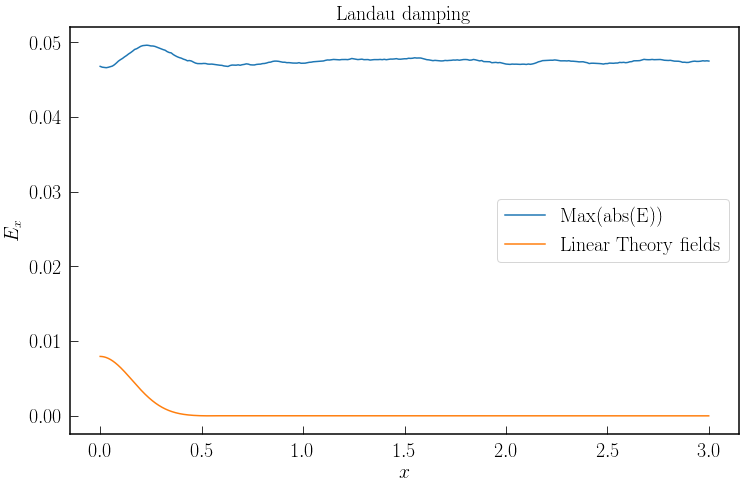

In [29]:
temp = np.linspace(0, time[-1], len(Ex_all_times))
pl.plot( temp, Ex_max , label = r'$\mathrm{Max(abs(E))}$')
pl.plot(time_ana, (abs(Ex_amp_real)),label = '$\mathrm{Linear\;Theory\;fields}$')
pl.title('$\mathrm{Landau\;damping}$')
pl.xlabel('$x$')
pl.ylabel('$E_{x}$')
pl.legend()
pl.show()
# pl.savefig('MaxE.png')
pl.clf()

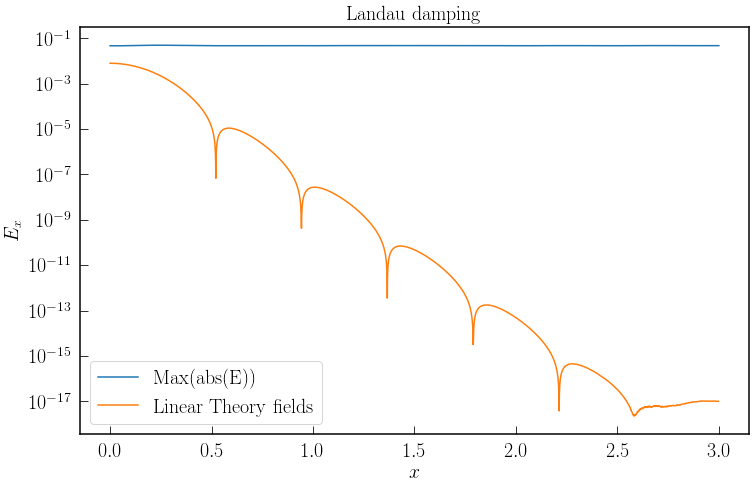

In [30]:
pl.semilogy(temp, Ex_max ,label = r'$\mathrm{Max(abs(E))}$')
pl.semilogy(time_ana, (abs(Ex_amp_real)),label = '$\mathrm{Linear\;Theory\;fields}$')
pl.legend()
pl.title('$\mathrm{Landau\;damping}$')
pl.xlabel('$x$')
pl.ylabel('$E_{x}$')
pl.show()
# pl.savefig('MaxE_semilogy.png')
pl.clf()

In [31]:
# print('ExAmp is ', Ex_amp)
# h5f = h5py.File('data_files/LT.h5', 'w')
# h5f.create_dataset('delta_rho1',   data = delta_rho1)
# h5f.create_dataset('delta_rho2',   data = delta_rho2)
# h5f.create_dataset('Ex_amp',   data = Ex_amp)
# h5f.close()
#
#
# h5f           = h5py.File('data_files/LT.h5', 'r')
# delta_rho1     = h5f['delta_rho1'][:]
# delta_rho2     = h5f['delta_rho2'][:]
# Ex_amp     = h5f['Ex_amp'][:]
# h5f.close()
#
# # print('data is ', data)
#
# # Plotting the required quantities here
# # pl.plot(time_ana, abs((Ex_amp)),label = '$LT1$')
# # pl.plot(time_ana, abs((Ex_amp2)),label = '$LT2$')
#
# # pl.plot(time_ana, (abs(delta_rho1)),label = '$\mathrm{Linear\;Theory\;fields}$')
# # pl.plot(time_ana, (abs(delta_rho2)),label = '$\mathrm{Linear\;Theory\;No\;fields}$')
# pl.plot(time_ana, (abs(Ex_amp_real)),label = '$\mathrm{Linear\;Theory\;fields}$')
# # pl.plot(time_mill,data,label = '$\mathrm{Numerical\;PIC}$')
#
# # pl.plot(time_mill, dataEx, label = '$\mathrm{Numerical\;PIC}$')
# # pl.plot(time_mill, data_energy, label = '$\mathrm{Numerical\;PIC\;Energy}$')
# pl.xlabel('$\mathrm{time}$')
# # pl.ylabel(r'$\delta \hat{\rho}\left(t\right)$')
# pl.ylabel('$\delta \hat{Ex}(t)$')
#
# pl.title('$\mathrm{Linear\;Landau\;damping}$')
# pl.legend()
# # pl.ylim(0, 0.01)
# # pl.xlim(0,2)
# pl.show()
# pl.clf()
#
# # pl.plot(time_ana, np.log(abs(Ex_amp)),label = '$LT1$')
# # pl.plot(time_ana, np.log(abs(Ex_amp2)),label = '$LT2$')
#
# pl.semilogy(time_ana, (abs(Ex_amp_real)),label = '$LT1$')
#
# # pl.plot(time_ana, np.log(abs(delta_rho1)),label = '$\mathrm{Linear\;Theory\;with\;fields}$')
# # pl.plot(time_ana, np.log(abs(delta_rho2)),label = '$\mathrm{Linear\;Theory\;No\;fields}$')
# pl.xlabel('$\mathrm{time}$')
# # pl.xlim(0,2)
# # pl.ylabel(r'$log(\delta \hat{\rho}\left(t\right))$')
# pl.ylabel(r'$\log(\delta \hat{E_{x}}\left(t\right))$')
# pl.title('$\mathrm{Linear\;Landau\;damping}$')
# pl.legend()
# pl.show()






# temp = np.linspace(0, time[-1], len(Ex_all_times))
# pl.plot( temp, Ex_all_times , label = r'$\mathrm{Average(abs(E))}$')
# pl.xlabel('$x$')
# pl.legend()
# pl.show()
# # pl.savefig('AbsE.png')
# pl.clf()
#
#
# # In[16]:
#
# pl.semilogy(temp, Ex_all_times ,label = r'$\mathrm{Average(abs(E))}$')
# pl.legend()
# pl.xlabel('$x$')
# pl.show()
# # pl.savefig('AbsE_semilogy.png')
# pl.clf()
#
#
# # In[17]:
#
# pl.loglog(temp, Ex_all_times ,label = r'$\mathrm{Average(abs(E))}$')
# pl.legend()
# pl.xlabel('$x$')
# pl.show()
# # pl.savefig('AbsE_semilogy.png')
# pl.clf()